Tests to implement:

1. KDD/GDD biases
2. LH/SH biases
3. Do these biases scale with ag production
4. Do these biases change over the growing season
5. Do historical cmip6 temperature biases predict future changes

In [77]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import cartopy
import cartopy.util
import cartopy.crs as ccrs
import glob
import sys, os
import pickle, gzip
import datetime

In [78]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [79]:
dirCmip6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirERA5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirDeepak = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate/deepak'
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirProj = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'
dirSacks = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'


In [80]:
# files = glob.glob('%s/cmip6_output/*.nc'%dirProj)
# for f in files:
#     os.rename(f,'%s.nc'%f[0:-4]) 

In [81]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)

In [82]:
cmip6_models = ['access-cm2', 'access-esm1-5', 'awi-cm-1-1-mr', 'bcc-csm2-mr', 'bcc-esm1', 'canesm5', 'ec-earth3', \
                'gfdl-cm4', 'gfdl-esm4', 'giss-e2-1-g', 'kace-1-0-g', 'fgoals-g3', 'inm-cm5-0', 'ipsl-cm6a-lr', 'miroc6', \
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr', 'mri-esm2-0', 'noresm2-lm', 'noresm2-mm', 'sam0-unicon']

In [83]:
region = 'global'
crop = 'Maize'
if region == 'global':
    latRange = [-90, 90]
    lonRange = [0, 360]
elif region == 'us':
    latRange = [20, 57]
    lonRange = [220, 300]
elif region == 'china':
    latRange = [25, 45]
    lonRange = [105, 123]
elif region == 'eu':
    latRange = [38, 56]
    lonRange = [-5, 40]

latIndRange_era5 = np.where((era5_lat >= latRange[0]) & (era5_lat <= latRange[1]))[0]
lonIndRange_era5 = np.where((era5_lon >= lonRange[0]) & (era5_lon <= lonRange[1]))[0]

regridMesh_current = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], 1.5)),
                            'lon': (['lon'], np.arange(lonRange[0], lonRange[1], 1.5)),})

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})


if region == 'global':
    regridMesh = regridMesh_global
else:
    regridMesh = regridMesh_current

In [84]:
sacksMaizeNc = xr.open_dataset('%s/sacks/%s.crop.calendar.fill.nc'%(dirSacks, crop))
sacksStart = sacksMaizeNc['plant'].values
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

In [85]:
with open('cropped_area/crop_land_regrid.dat', 'rb') as f:
    crop_all_area_regrid = pickle.load(f)
with open('cropped_area/pasture_land_regrid.dat', 'rb') as f:
    pasture_area_regrid = pickle.load(f)

In [86]:
cmip6_tasmax_grow_max_trend = xr.Dataset()
cmip6_tasmax_grow_mean_trend = xr.Dataset()
cmip6_ef_grow_trend = xr.Dataset()

ef_m = 0

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_%s_grow_max_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model)):
        print('skipping %s, base file DOESNT EXIST'%model)
        continue
    
    print('loading growing season trends for %s'%model)

    if os.path.isfile('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_trend_global_%s_regrid.nc'%(crop, model)):
        ds_global_ef_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_grow_ef_mon_trend_global_%s_regrid.nc'%(crop, model))
        
        if ef_m == 0:
            cmip6_ef_grow_trend = ds_global_ef_trend
        else:
            cmip6_ef_grow_trend = xr.concat([cmip6_ef_grow_trend, ds_global_ef_trend], dim='model')
        ef_m += 1
    else:
        print('skipping ef %s'%model)
    
    ds_global_txx_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_%s_grow_max_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model))
    ds_global_t50p_trend = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_%s_grow_mean_trend_%s_%s_regrid.nc'%(crop, 'tasmax', region, model))

    if m == 0:
        cmip6_tasmax_grow_max_trend = ds_global_txx_trend
        cmip6_tasmax_grow_mean_trend = ds_global_t50p_trend
    else:
        cmip6_tasmax_grow_max_trend = xr.concat([cmip6_tasmax_grow_max_trend, ds_global_txx_trend], dim='model')
        cmip6_tasmax_grow_mean_trend = xr.concat([cmip6_tasmax_grow_mean_trend, ds_global_t50p_trend], dim='model')



loading growing season trends for access-cm2
loading growing season trends for access-esm1-5
loading growing season trends for awi-cm-1-1-mr
loading growing season trends for bcc-csm2-mr
loading growing season trends for bcc-esm1
loading growing season trends for canesm5
loading growing season trends for ec-earth3
loading growing season trends for gfdl-cm4
skipping ef gfdl-cm4
loading growing season trends for gfdl-esm4
skipping ef gfdl-esm4
loading growing season trends for giss-e2-1-g
loading growing season trends for kace-1-0-g
skipping ef kace-1-0-g
loading growing season trends for fgoals-g3
loading growing season trends for inm-cm5-0
loading growing season trends for ipsl-cm6a-lr
loading growing season trends for miroc6
loading growing season trends for mpi-esm1-2-hr
loading growing season trends for mpi-esm1-2-lr
loading growing season trends for mri-esm2-0
loading growing season trends for noresm2-lm
loading growing season trends for noresm2-mm
loading growing season trends for

In [87]:
%%time

# era5 trends for growing season data
era5_tasmax_grow_max_trend = xr.open_dataset('era5/growing_season/era5_tasmax_grow_max_trend_%s.nc'%region)
era5_tasmax_grow_mean_trend = xr.open_dataset('era5/growing_season/era5_tasmax_grow_mean_trend_%s.nc'%region)    
era5_ef_grow_trend = xr.open_dataset('era5/growing_season/era5_ef_grow_trend_%s.nc'%region)
era5_pr_grow_trend = xr.open_dataset('era5/growing_season/era5_pr_grow_trend_%s.nc'%region)
era5_tran_grow_trend = xr.open_dataset('era5/growing_season/era5_trans_grow_trend_%s.nc'%region)
era5_evap_from_canopy_grow_trend = xr.open_dataset('era5/growing_season/era5_evap_from_canopy_grow_trend_%s.nc'%region)
era5_evap_from_soil_grow_trend = xr.open_dataset('era5/growing_season/era5_evap_from_soil_grow_trend_%s.nc'%region)

CPU times: user 14.6 ms, sys: 289 µs, total: 14.9 ms
Wall time: 13.9 ms


In [88]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely import geometry
from collections import namedtuple
from shapely.geometry.polygon import LinearRing

def plot_polygon(ax, sub_region):
    """
    https://groups.google.com/forum/#!topic/scitools-iris/LxR0EbQolyE
    Note:
    ----
    order is important:
        lower-left, upper-left, upper-right, lower-right
        2 -- 3
        |    |
        1 -- 4
    """
    # ax = fig.axes[0]
    lats = [sub_region.latmin, sub_region.latmin, sub_region.latmax, sub_region.latmax]
    lons = [sub_region.lonmin, sub_region.lonmax, sub_region.lonmax, sub_region.lonmin]
    ring = LinearRing(list(zip(lons, lats)))
    ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=2)
    return ax


Region = namedtuple('Region',field_names=['region_name','lonmin','lonmax','latmin','latmax'])

region_us = Region(
    region_name="Midwest",
    lonmin = -115,
    lonmax = -80,
    latmin = 30,
    latmax = 55,
)

region_europe = Region(
    region_name="Europe",
    lonmin = 0,
    lonmax = 60,
    latmin = 35,
    latmax = 55,
)

region_india = Region(
    region_name="India",
    lonmin = 68,
    lonmax = 90,
    latmin = 5,
    latmax = 35,
)

region_china = Region(
    region_name="China",
    lonmin = 100,
    lonmax = 130,
    latmin = 20,
    latmax = 48,
)

region_sahel = Region(
    region_name="Sahel",
    lonmin = -15,
    lonmax = 50,
    latmin = 2,
    latmax = 17,
)

region_sa = Region(
    region_name="SA",
    lonmin = -68,
    lonmax = -50,
    latmin = -48,
    latmax = -25,
)

In [89]:
era5_tasmax_grow_max_trend

<xarray.Dataset>
Dimensions:                (lat: 120, lon: 240)
Coordinates:
  * lat                    (lat) float64 -90.0 -88.5 -87.0 ... 85.5 87.0 88.5
  * lon                    (lon) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
Data variables:
    tasmax_grow_max_trend  (lat, lon) float64 ...

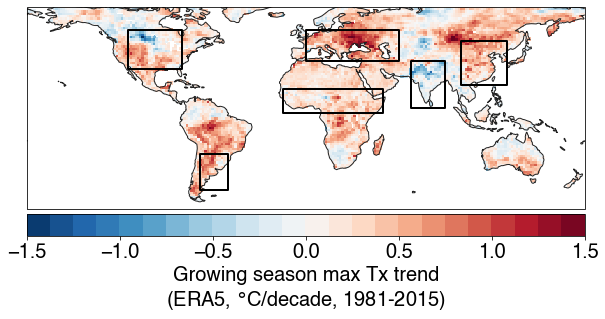

In [119]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -1.5
v2 = 1.51
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('RdBu_r')

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], era5_tasmax_grow_max_trend.tasmax_grow_max_trend.values, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plot_polygon(ax, region_us)
plot_polygon(ax, region_europe)
plot_polygon(ax, region_india)
plot_polygon(ax, region_china)
plot_polygon(ax, region_sahel)
plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season max Tx trend\n(ERA5, $\degree$C/decade, 1981-2015)', fontsize=20)

plt.savefig('tx-trend-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [91]:
cmip6_era5_tasmax_grow_max_trend_bias = np.full(cmip6_tasmax_grow_max_trend.tasmax_grow_max_trend.values.shape, np.nan)

for m in range(cmip6_tasmax_grow_max_trend.tasmax_grow_max_trend.values.shape[0]):
    cmip6_era5_tasmax_grow_max_trend_bias[m, :, :] = cmip6_tasmax_grow_max_trend.tasmax_grow_max_trend.values[m, :, :] - era5_tasmax_grow_max_trend.tasmax_grow_max_trend.values

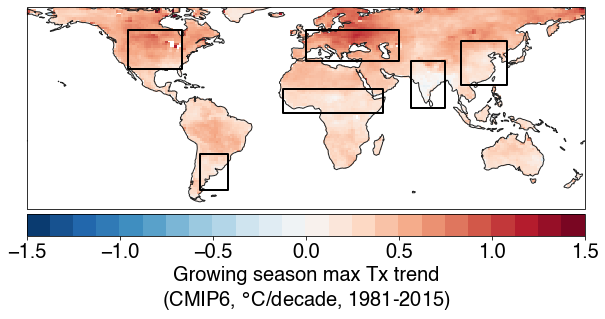

In [120]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -1.5
v2 = 1.51
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('RdBu_r')

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], np.nanmean(cmip6_tasmax_grow_max_trend.tasmax_grow_max_trend.values, axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plot_polygon(ax, region_us)
plot_polygon(ax, region_europe)
plot_polygon(ax, region_india)
plot_polygon(ax, region_china)
plot_polygon(ax, region_sahel)
plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season max Tx trend\n(CMIP6, $\degree$C/decade, 1981-2015)', fontsize=20)

plt.savefig('tx-trend-cmip6-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

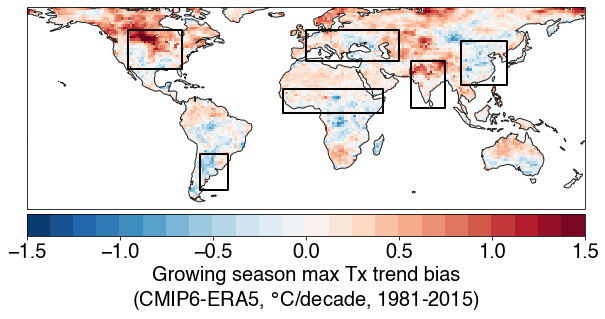

In [118]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

ax.set_extent([-180, -180, 70, -60])

v1 = -1.5
v2 = 1.51
vstep = .125
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('RdBu_r')

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], np.nanmean(cmip6_era5_tasmax_grow_max_trend_bias, axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

plot_polygon(ax, region_us)
plot_polygon(ax, region_europe)
plot_polygon(ax, region_india)
plot_polygon(ax, region_china)
plot_polygon(ax, region_sahel)
plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season max Tx trend bias\n(CMIP6-ERA5, $\degree$C/decade, 1981-2015)', fontsize=20)

plt.savefig('tx-trend-bias-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [94]:
# crop_ha_regrid_15_1d = np.reshape(crop_ha_regrid_15, [crop_ha_regrid_15.size,1])
# crop_all_ha_regrid_15_1d = np.reshape(crop_all_ha_regrid_15, [crop_all_ha_regrid_15.size,1])
# crop_ha_chg_regrid_15_1d = np.reshape(crop_ha_chg_regrid_15, [crop_ha_chg_regrid_15.size,1])

In [96]:
crop_all_area_regrid_1d = np.reshape(crop_all_area_regrid, [crop_all_area_regrid.size,1])

In [97]:
%%time
if not os.path.isfile('irrigation_data_regrid_120_240.dat'):
    faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dirAgData
    irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
    irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
    irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
    irrigationLon[irrigationLon<0] += 360

    regridder = xe.Regridder(xr.DataArray(data=irrigationData, dims=['lat', 'lon'], coords={'lat':irrigationLat, 'lon':irrigationLon}), regridMesh, 'bilinear')
    irrigation_data_regrid = regridder(irrigationData)

    with open('irrigation_data_regrid_120_240.dat', 'wb') as f:
        pickle.dump(irrigation_data_regrid, f)
else:
    with open('irrigation_data_regrid_120_240.dat', 'rb') as f:
        irrigation_data_regrid = pickle.load(f)
    irrigation_data_regrid[irrigation_data_regrid == 0] = np.nan
    irrigation_data_regrid /= 100
    irrigation_data_regrid_1d = irrigation_data_regrid.reshape([irrigation_data_regrid.shape[0]*irrigation_data_regrid.shape[1],1])

CPU times: user 1.76 ms, sys: 316 µs, total: 2.07 ms
Wall time: 51.2 ms


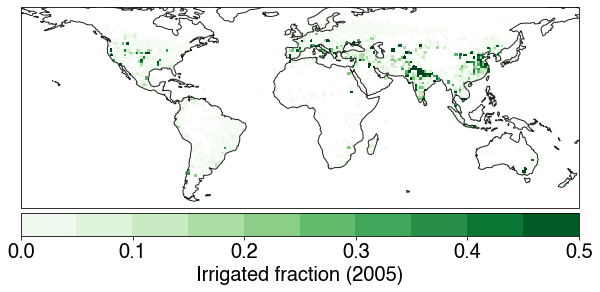

In [98]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = .51
vstep = .05
vlabelstep = .10

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')
c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], irrigation_data_regrid, cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Irrigated fraction (2005)', fontsize=20)

In [100]:
era5_tasmax_grow_max_trend_1d = era5_tasmax_grow_max_trend.tasmax_grow_max_trend.values.reshape([era5_tasmax_grow_max_trend.lat.values.size*era5_tasmax_grow_max_trend.lon.values.size])

cmip6_tasmax_grow_max_trend_1d = np.nanmean(cmip6_tasmax_grow_max_trend.tasmax_grow_max_trend.values, axis=0)
cmip6_tasmax_grow_max_trend_1d = cmip6_tasmax_grow_max_trend_1d.reshape([cmip6_tasmax_grow_max_trend_1d.shape[0]*cmip6_tasmax_grow_max_trend_1d.shape[1]])

cmip6_era5_tasmax_grow_max_trend_bias_2d = cmip6_era5_tasmax_grow_max_trend_bias.reshape([cmip6_era5_tasmax_grow_max_trend_bias.shape[0], cmip6_era5_tasmax_grow_max_trend_bias.shape[1]*cmip6_era5_tasmax_grow_max_trend_bias.shape[2]])

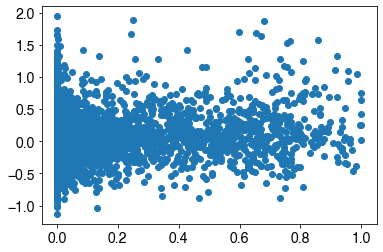

In [124]:
plt.scatter(crop_all_area_regrid_1d,np.nanmean(cmip6_era5_tasmax_grow_max_trend_bias_2d, axis=0))

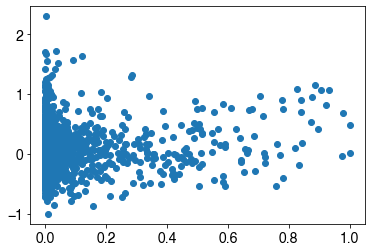

In [122]:
plt.scatter(irrigation_data_regrid_1d,np.nanmean(cmip6_era5_tasmax_grow_max_trend_bias_2d, axis=0))

In [102]:
bins = [0,.01,.05,.1,.2,.3, .4, .5, .6, .7, .8]
binned_tx_max_era5 = []
binned_tx_max_cmip6_mean = []
binned_tx_max_cmip6_era5_bias_mean = []
binned_tx_max_cmip6_era5_bias_per_model = []

for b,bcur in enumerate(bins):
    if b == len(bins)-1:
        ind = np.where((~np.isnan(crop_all_area_regrid_1d)) & (crop_all_area_regrid_1d >= bcur))[0]
    else:
        ind = np.where((~np.isnan(crop_all_area_regrid_1d)) & (crop_all_area_regrid_1d >= bcur) & (crop_all_area_regrid_1d < bins[b+1]))[0]
    
    binned_tx_max_era5.append(np.nanmean(era5_tasmax_grow_max_trend_1d[ind]))
    binned_tx_max_cmip6_mean.append(np.nanmean(cmip6_tasmax_grow_max_trend_1d[ind]))
    binned_tx_max_cmip6_era5_bias_mean.append(np.nanmean(cmip6_era5_tasmax_grow_max_trend_bias_2d[:,ind]))
    
    for m in range(cmip6_era5_tasmax_grow_max_trend_bias_2d.shape[0]):
        if b == 0:
            binned_tx_max_cmip6_era5_bias_per_model.append([np.nanmean(cmip6_era5_tasmax_grow_max_trend_bias_2d[m,ind])])
        else:
            binned_tx_max_cmip6_era5_bias_per_model[m].append(np.nanmean(cmip6_era5_tasmax_grow_max_trend_bias_2d[m,ind]))
            
binned_tx_max_era5 = np.array(binned_tx_max_era5)
binned_tx_max_cmip6_mean = np.array(binned_tx_max_cmip6_mean)
binned_tx_max_cmip6_era5_bias_per_model = np.array(binned_tx_max_cmip6_era5_bias_per_model)

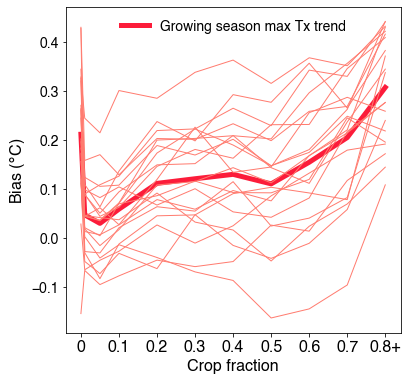

In [117]:
plt.figure(figsize=(6,6))
plt.plot(bins, binned_tx_max_cmip6_era5_bias_mean, label='Growing season max Tx trend', lw=5, c='#fc1c3a')
plt.plot(bins, binned_tx_max_cmip6_era5_bias_per_model.T, lw=1, c='#ff7c70')


plt.xlabel('Crop fraction', fontsize=16)
plt.xticks(np.arange(0, .81, .1))
plt.gca().set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8+'], fontsize=16)
plt.ylabel('Bias ($\degree$C)', fontsize=16)
plt.legend(prop={'size': 14}, frameon=False)


# plt.tight_layout()

plt.savefig('binned-tx-biases-cmip6-trend-mean.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)